In [5]:
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
# Alternative generator architecture

# class encoder(nn.Module):
#     def __init__(self,input_channels,output_channels,normalize=True,dropout=0.0):
#         super(encoder,self).__init__()
        
#         layers=[nn.Conv2d(input_channels,output_channels,4,2,1,bias=False)]
#         if normalize:
#             layers.append(nn.InstanceNorm2d(output_channels))
#         layers.append(nn.LeakyReLU(0.2))
#         if dropout:
#             layers.append(nn.Dropout(dropout))
#         self.model=nn.Sequential(*layers)
        
#     def forward(self,x):
#         return self.model(x)
    
# class decoder(nn.Module):
#     def __init__(self,input_channels,output_channels,dropout=0.0):
#         super(decoder,self).__init__()
#         layers=[
#             nn.ConvTranspose2d(input_channels,output_channels,4,2,1,bias=False),
#             nn.InstanceNorm2d(output_channels),
#             nn.ReLU(inplace=True)
#         ]
#         if dropout:
#             layers.append(nn.Dropout(dropout))
            
#         self.model=nn.Sequential(*layers)
    
#     def forward(self,x,skip_input):
#         x=self.model(x)
#         x=torch.cat((x,skip_input),1) # torch.cat(tensors, dim=0, *, out=None) → Tensor(here 1 represents concatenation along columns)
        
#         return x
    
    
# class generator(nn.Module):
#     def __init__(self,input_channels=3,output_channels=3):
#         super(generator,self).__init__()
#         # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
#         self.down1=self.model(input_channels,64,normalize=False)
#         self.down2=self.model(64,128)
#         self.down3=self.model(128,256)
#         self.down4=self.model(256,512)
#         self.down5=self.model(512,512)
#         self.down6=self.model(512,512)
#         self.down7=self.model(512,512)
        
#         self.bottle_neck=self.model(512,512,normalize=False) #bottleneck layer
        
#         # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
#         self.up1=self.model(512,512,dropout=0.5)
#         self.up2=self.model(512*2,512,dropout=0.5)
#         self.up3=self.model(512*2,512,dropout=0.5)
#         self.up4=self.model(512*2,512,dropout=0.5)
#         self.up5=self.model(512*2,256)
#         self.up6=self.model(256*2,128)
#         self.up7=self.model(128*2,64)
        
#         self.final_up=nn.Sequential(
#         nn.ConvTranspose2d(64*2,out_channels,4,2,1),
#         nn.Tanh(),
#         )
        
#         def forward(self,x):
#             d1=self.down1(x)
#             d2=self.down2(d1)
#             d3=self.down3(d2) 
#             d4=self.down4(d3)
#             d5=self.down5(d4)
#             d6=self.down6(d5)
#             d7=self.down7(d6)
            
#             bottle_neck=self.bottle_neck(d7)
            
#             u1=self.up1(bottle_neck,d7)
#             u2=self.up2(u1,d6)
#             u3=self.up3(u2,d5)
#             u4=self.up4(u3,d4)
#             u5=self.up5(u4,d3)
#             u6=self.up6(u5,d2)
#             u7=self.up7(u6,d1)
            
#             return self.final_up(u7)
                

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET              
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [16]:
# D = Discriminator()
# D(torch.randn(1,3,256,256), torch.randn(1,3,256,256)).shape

torch.Size([1, 1, 16, 16])

In [ ]:
#class discriminator(nn.Module):
    #def __init__(self,input_channels=3):
        #super(discriminator,self).__init__()


        
#         self.block_1=nn.Sequential(
#                 nn.Conv2d(input_channels*2,64,kernel_size=(4,4),stride=(2,2),padding=1),
#                 nn.LeakyReLU(0.2)
#                 )
#         self.block_2=nn.Sequential(
#                 nn.Conv2d(64,128,kernel_size=(4,4),stride=(2,2),padding=1),
#                 nn.BatchNorm2d(128),
#                 nn.LeakyReLU(0.2)
#                 )
#         self.block_3=nn.Sequential(
#                 nn.Conv2d(128,256,kernel_size=(4,4),stride=(2,2),padding=1),
#                 nn.BatchNorm2d(256),
#                 nn.LeakyReLU(0.2)
#                 )
#         self.block_4=nn.Sequential(
#                 nn.Conv2d(256,512,kernel_size=(4,4),stride=(2,2),padding=1),
#                 nn.BatchNorm2d(512),
#                 nn.LeakyReLU(0.2)
#                 )
#         self.block_5=nn.ZeroPad2d((1, 0, 1, 0))
#         self.block_6=nn.Sequential(
#                 nn.Conv2d(512,1,kernel_size=(4,4),stride=(1,1),padding=1),
#                 nn.Sigmoid()
#                 )
#     def forward(self,x,y):
#         input=torch.cat([x,y],dim=1)
#         out=self.block_1(input)
#         out=self.block_2(out)
#         out=self.block_3(out)
#         out=self.block_4(out)
#         out=self.block_5(out)
#         out=self.block_6(out)
      
        
#         return out
            
    
# def test():
#     x=torch.randn((1,3,286,286))
#     y=torch.randn((1,3,286,286))
#     preds=discriminator(input_channels=3)
#     output=preds(x,y)
#     print(output.shape)
    

In [17]:
class Arial2Map(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.file = root + '/maps/maps/train/'
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.file))
    
    def __getitem__(self, idx):
        img = Image.open(self.file + str(idx+1) + '.jpg')
        w, h = img.size
        img_A = img.crop((0, 0, w/2, h))
        img_B = img.crop((w/2, 0, w, h))
        
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        return {'arial':img_A, 'map':img_B}
    

In [18]:
transform = transforms.Compose([
                    transforms.Resize((256,256)),
                    transforms.ToTensor()
            ])

In [19]:
train_data = Arial2Map('../input/pix2pix-dataset', transform=transform)


In [20]:
len(train_data)

1096

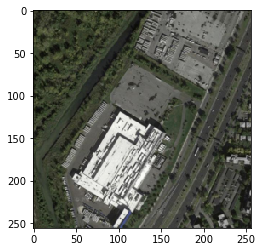

In [21]:
plt.imshow(train_data[71]['arial'].permute(1,2,0))

In [22]:
dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                        shuffle=True,
                                        batch_size=2)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
device

device(type='cuda')

In [24]:
D_loss = []
G_loss = []

In [25]:
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()
lambda_pixel = 100
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [26]:
for epoch in range(epochs):
    for i, imgs in enumerate(dataloader):
        real_arials = imgs['arial'].to(device)
        real_maps = imgs['map'].to(device)
        
        valid = torch.ones(real_arials.shape[0], 1, 16, 16).to(device)
        fake = torch.zeros(real_arials.shape[0], 1, 16, 16).to(device)
        
        
        #train generator
        
        fake_maps = generator(real_arials)
        
        pred_fake = discriminator(fake_maps, real_arials)
        GAN_loss = criterion_GAN(pred_fake, valid)
        
        #pixel_wise loss
        l1_loss = criterion_pixelwise(fake_maps, real_maps)
        
        loss_G = GAN_loss + lambda_pixel*l1_loss
        
        generator.zero_grad()
        loss_G.backward()
        
        optimizer_G.step()
        
        #train discriminator
        
        pred_real = discriminator(real_maps, real_arials)
        loss_real = criterion_GAN(pred_real, valid)
        
        pred_fake = discriminator(fake_maps.detach(), real_arials)
        loss_fake = criterion_GAN(pred_fake, fake)
        
        loss_D = (loss_real + loss_fake)/2
        
        discriminator.zero_grad()
        loss_D.backward()
        
        optimizer_D.step()
        
        D_loss.append(loss_D.item())
        G_loss.append(loss_G.item())
        
        
        if(i+1)%500==0:
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f adv: %f]\n"
                % (
                    epoch,
                    epochs,
                    i,
                    len(dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    GAN_loss.item(),
                )
            )

        
                     

[Epoch 0/100] [Batch 499/548] [D loss: 0.173649] [G loss: 5.659893 adv: 0.402095]
[Epoch 1/100] [Batch 499/548] [D loss: 0.129114] [G loss: 5.857745 adv: 0.798140]
[Epoch 2/100] [Batch 499/548] [D loss: 0.089270] [G loss: 6.186213 adv: 0.792900]
[Epoch 3/100] [Batch 499/548] [D loss: 0.129052] [G loss: 4.271102 adv: 0.644780]
[Epoch 4/100] [Batch 499/548] [D loss: 0.088573] [G loss: 3.423606 adv: 0.430784]
[Epoch 5/100] [Batch 499/548] [D loss: 0.107238] [G loss: 3.573461 adv: 0.358228]
[Epoch 6/100] [Batch 499/548] [D loss: 0.143167] [G loss: 2.724664 adv: 0.328419]
[Epoch 7/100] [Batch 499/548] [D loss: 0.096288] [G loss: 4.330742 adv: 0.418352]
[Epoch 8/100] [Batch 499/548] [D loss: 0.058602] [G loss: 5.131230 adv: 1.088214]
[Epoch 9/100] [Batch 499/548] [D loss: 0.139911] [G loss: 4.658551 adv: 1.188077]
[Epoch 10/100] [Batch 499/548] [D loss: 0.084054] [G loss: 2.393938 adv: 0.503043]
[Epoch 11/100] [Batch 499/548] [D loss: 0.067335] [G loss: 5.990777 adv: 1.186910]
[Epoch 12/100]

In [27]:
out = generator(train_data[89]['arial'].unsqueeze(0).to(device))

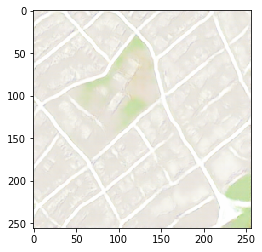

In [28]:
plt.imshow(out.detach().cpu().squeeze(0).permute(1,2,0))

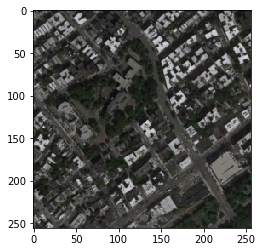

In [29]:
plt.imshow(train_data[89]['arial'].permute(1,2,0))

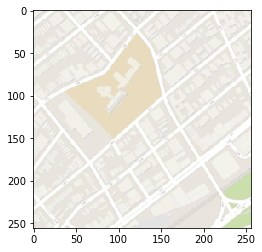

In [30]:
plt.imshow(train_data[89]['map'].permute(1,2,0))